In [12]:
import pennylane as qml
from pennylane import numpy as np
from utils import QCNN_circuit, Benchmarking, unitary, embedding
import matplotlib.pyplot as plt
from scipy.linalg import eigh, expm
import qutip

# Ising model

## Generating testing dataset

In [13]:
# Generate Hamiltonian
def ising_hamiltonian(L, J, h):
        pauli_x = np.array([[0,1],[1,0]])
        pauli_z = np.array([[1,0],[0,-1]])
        id = np.eye(2)

        sx_list = []
        sz_list = []
        for i_site in range(L):
                z_ops = [id] * L
                x_ops = [id] * L
                z_ops[i_site] = pauli_z
                x_ops[i_site] = pauli_x
                ZZ = z_ops[0]
                X =  x_ops[0]
                for j in range(1, L):
                        ZZ = np.kron(ZZ, z_ops[j])
                        X = np.kron(X, x_ops[j])
                sz_list.append(ZZ)
                sx_list.append(X)
        H_zz = np.zeros((2**L, 2**L))
        H_x = np.zeros((2**L, 2**L))

        for i in range(L-1):
                H_zz += np.matmul(sz_list[i], sz_list[(i + 1)])
                H_x += sx_list[i]

        H_x += sx_list[L-1]

        return np.matrix(-J * H_zz - h * H_x)

# Magnetization operator
def M(L):
        pauli_z = np.array([[1,0],[0,-1]])
        id = np.eye(2)

        sz_list = []
        for i_site in range(L):
                z_ops = [id] * L
                z_ops[i_site] = pauli_z
                Z = z_ops[0]
                for j in range(1, L):
                        Z = np.kron(Z, z_ops[j])
                sz_list.append(Z)
        H_z = np.zeros((2**L, 2**L))

        for i in range(L):
                H_z += sz_list[i]
        return np.matrix(H_z)/L

In [14]:
L = 8

h_list = np.arange(1000)/2000
M_op = M(L)
ground_energies = []
ground_states = []
magnetization = []
for h in h_list:
    energy, state = eigh(ising_hamiltonian(L, 1, h), eigvals_only = False)
    ground_energies.append(min(energy))
    ground_states.append(state[:, np.argmin(energy)])
    ket = np.transpose([ground_states[-1]])
    m = np.matmul(np.matrix(ket).H, np.matmul(M_op, ket))
    magnetization.append(m.item())

## Test and Analysis

In [15]:
ansatz = 'U_SU4'
U_params = 15
Embedding = 'Statevector'

In [16]:
# Regression model
params_ising_regression = np.array([0.34484976, -0.28182233, -0.97583034, -1.50284213, -1.575846,    1.65898698,
 -0.85920524,  0.40488789, -1.57277551,  0.44711323, -0.61537749, -0.39033801,
 -2.24276353, -2.64576165, -1.09133645, -0.33006222,  0.32891585,  0.47062225,
  0.17388104, -0.55350894,  0.05721447,  1.61864024,  1.57273429, -1.53038872,
 -0.00724897,  1.20235452,  0.01119348, -1.69642161,  0.13043329, -0.33715001,
  0.11057712,  0.47717991,  0.97122175,  1.30935699, -0.23240944, -0.66083709,
  0.04738152, -2.70902228,  0.06163599, -0.21079841,  0.77414923, -0.70443353,
  0.39859975, -0.31522218, -1.54637845, -0.57939689,  0.7585887,  -0.4308167,
  0.15577493, -1.06197993, -0.35725969], requires_grad=False)
pred_ising_regression = [QCNN_circuit.QCNN(x, params_ising_regression, ansatz, U_params, Embedding, 'mse') for x in ground_states]

In [17]:
# Classification model
params_ising_classification = np.array([-1.67052715, -0.13960295, -1.44263913,  1.42629904, -1.57699025, -1.42661246,
 -0.0522651,   0.36006748, -0.67960293,  1.95330868,  0.33351853,  0.5308162,
  1.97197246,  2.56194399, -0.75842963, -1.17872073,  0.16903734, -0.0448714,
  0.19966097, -0.69506634, -0.44336661,  0.98345108, -0.14492528,  0.4575735,
  0.06297951, -0.29277664,  1.20919848, -0.9150824,  -1.27277018,  0.6203437,
  1.24970541,  0.25263028, -0.04389448, -0.3078665,  -1.1703178,  0.46131751,
 -0.63067362, -0.61068373,  0.27886913, -1.64106485,  0.68796445, -0.69708568,
 -0.82012701,  0.58291784,  0.52630972, -0.13215771,  0.05656713, -0.16384511,
  0.20406278,  0.12460617, -0.27353643])
pred_ising_classification = [QCNN_circuit.QCNN(x, params_ising_classification, ansatz, U_params, Embedding, 'cross_entropy') for x in ground_states]

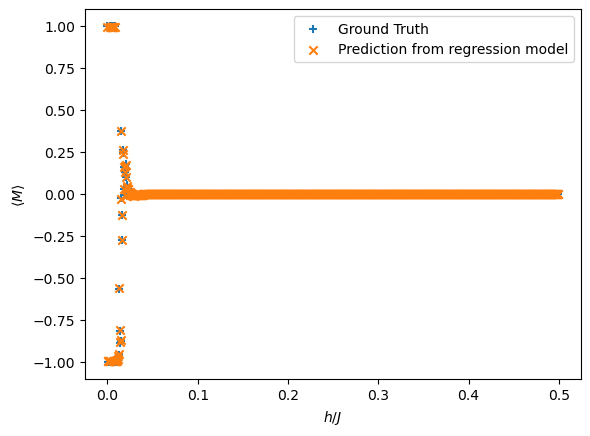

In [18]:
plt.scatter(h_list, magnetization, marker = '+', label = 'Ground Truth')
plt.scatter(h_list, pred_ising_regression, marker = "x", label = 'Prediction from regression model')
plt.xlabel(r"$h/J$")
plt.ylabel(r"$\langle M\rangle$")
plt.legend()
# plt.savefig('plots/regression_ising.pdf')
plt.show()

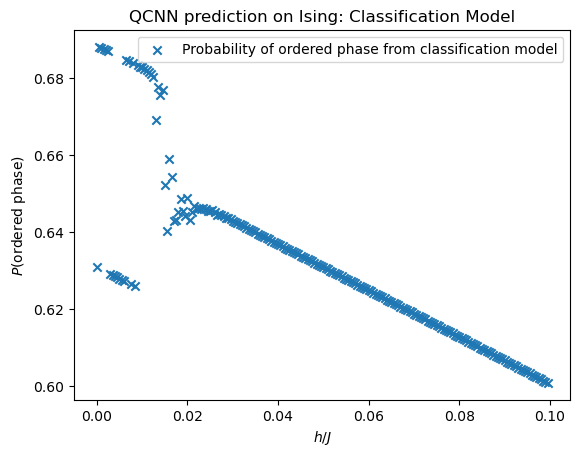

In [19]:
plt.scatter(h_list[:200], [x[1] for x in pred_ising_classification][:200], marker = "x", label = 'Probability of ordered phase from classification model')
plt.xlabel(r"$h/J$")
plt.ylabel(r"$P$(ordered phase)")
plt.legend()
plt.title(r'QCNN prediction on Ising: Classification Model')
# plt.savefig('plots/classification_ising.pdf')
plt.show()

# $Z_2\times Z_2$ SPT phase

## Generating Testig dataset

In [20]:
# Generate Hamiltonian
def spt_hamiltonian(L, J, h):
        pauli_x = np.array([[0,1],[1,0]])
        pauli_z = np.array([[1,0],[0,-1]])
        id = np.eye(2)

        sx_list = []
        sz_list = []
        for i_site in range(L):
                z_ops = [id] * L
                x_ops = [id] * L
                z_ops[i_site] = pauli_z
                x_ops[i_site] = pauli_x
                ZZ = z_ops[0]
                X =  x_ops[0]
                for j in range(1, L):
                        ZZ = np.kron(ZZ, z_ops[j])
                        X = np.kron(X, x_ops[j])
                sz_list.append(ZZ)
                sx_list.append(X)
        H_zxz = np.zeros((2**L, 2**L))
        H_xx = np.zeros((2**L, 2**L))

        for i in range(L-2):
                H_zxz += np.matmul(sz_list[i], np.matmul(sx_list[i+1], sz_list[(i + 2)]))
                H_xx += np.matmul(sx_list[i], sx_list[i+1])

        H_xx += np.matmul(sx_list[L-2], sx_list[L-1])

        return np.matrix(-J * H_zxz - h * H_xx)

def stringOp(L):
        pauli_x = np.array([[0,1],[1,0]])
        pauli_z = np.array([[1,0],[0,-1]])
        id = np.eye(2)
        
        ops = [id]*L
        if L%2 == 1:
                ops[0] = pauli_z
                ops[-1] = pauli_z
                for i in range(1, L-1, 2):
                        ops[i] = pauli_x
        elif L%2 == 0:
                ops[0] = pauli_z
                ops[L-2] = pauli_z 
                for i in range(1, L-2, 2):
                        ops[i] = pauli_x
        
        out = ops[0]
        for i in range(1, L):
                out = np.kron(out, ops[i])
                
        

        
        return out
        
        
        


In [21]:
# Generate ground states
L = 8

h_list_spt = (6*np.random.rand(1000) - 3)


ground_energies_spt = []
ground_states_spt = []

orderParams = []

op = stringOp(L)
for h in h_list_spt:
    energy, state = eigh(spt_hamiltonian(L, 1, h), eigvals_only = False)
    ground_energies_spt.append(min(energy))
    ground_states_spt.append(state[:, np.argmin(energy)])
    ket = np.transpose([ground_states_spt[-1]])
    m = np.matmul(np.matrix(ket).H, np.matmul(op, ket))
    orderParams.append(m.item())

In [22]:
# Regression model
params_spt_regression = np.array([-0.35130076,  2.20147317,  0.4685366,  -0.11863158, -1.02904303,  0.23908072,
 -1.23517294,  0.27082562,  1.18944713,  0.05485146,  1.69398049,  0.98168833,
 -2.10962073, -0.8272562,   0.49564486, -1.56368582, -0.58283765,  0.83238825,
  0.01620159, -1.326686,   -0.41372758, -0.24921912, -2.30927844,  0.3357681,
  1.26383322, -1.44975513, -0.55086913,  1.07589775,  0.74656593, -2.29108514,
 -1.28677819,  1.81730066, -1.16639177,  2.20526573,  0.63912209,  0.30178217,
 -1.14256607,  0.70645885,  1.58831076, -0.85044413,  2.16992461, -0.72336096,
  0.68924927,  0.46234245, -2.07298505,  1.01307697,  0.64194001, -0.1594233,
 -1.12720285,  0.91683663,  2.22453806])
pred_spt_regression = [QCNN_circuit.QCNN(x, params_spt_regression, ansatz, U_params, Embedding, 'mse') for x in ground_states_spt]

In [23]:
# # Regression model (need to manually adjust the circuit when running this part)
# params_spt_regression_nonlocal = np.array([1.50152691,  0.01134103,  0.7679803,   1.43931425,  1.20196002,  3.66553592,
#  -1.47813508,  1.04913916, -0.10632825, -0.51771262,  0.52174651,  0.57305252,
#  -0.09214513, -0.17958393, -0.12575229,  1.06235558, -0.44407962, -0.45301566,
#   0.61530694,  1.54452289, 0.33346194, -1.35576236,  1.00062196, -0.44011033,
#   0.93512921,  0.96623734,  0.74805109, -2.69924193, -3.5073127,  -1.0384302,
#   2.29310105,  0.06342262, -0.50515334, -1.23258085, -1.17574157, -0.74604092,
#  -1.84700779,  2.27545944,  1.11825412,  0.79854842,  0.01354263,  0.80740295,
#   1.50361449,  3.72259977,  0.52363521, -1.25015176, -1.35612852, -0.70730102,
#  -0.30147428,  0.39074976, -3.16695706])
# pred_spt_regression_nonlocal = [QCNN_circuit.QCNN(x, params_spt_regression_nonlocal, ansatz, U_params, Embedding, 'mse') for x in ground_states_spt]

In [24]:
# Classification model (need to manually adjust the circuit when running this part)
params_spt_classification = np.array([ 1.34997347, -0.5961782,  -0.22721047,  1.32389429,  0.80475892,  0.68645118,
  0.78866999, -1.01863644,  0.36911719, -0.82536382, -1.28512757, -0.33128837,
  0.89345912, -0.10464479,  1.34334647, -0.56378938,  0.91228888,  0.10069741,
 -1.36509387,  1.14734965,  0.14618884,  0.93462035, -0.56671156, 0.07655294,
 -1.36675415, -0.87182582,  0.53219541, -0.64893055, -0.88277993,  0.18293593,
 -0.07694187, 0.51850771,  0.72463968,  0.26355864, -0.27837084,  0.6427979,
 -1.66253992,  0.80206577, -0.948372,   -0.2791456,  -0.85325911,  0.26414673,
 -0.54576039, -1.14766264, -2.4007109,   1.59266456,  0.9674669,  -2.21023545,
 -2.59493948,  1.59054295, -0.16058579])
pred_spt_classification = [QCNN_circuit.QCNN(x, params_spt_classification, ansatz, U_params, Embedding, 'cross_entropy') for x in ground_states_spt]

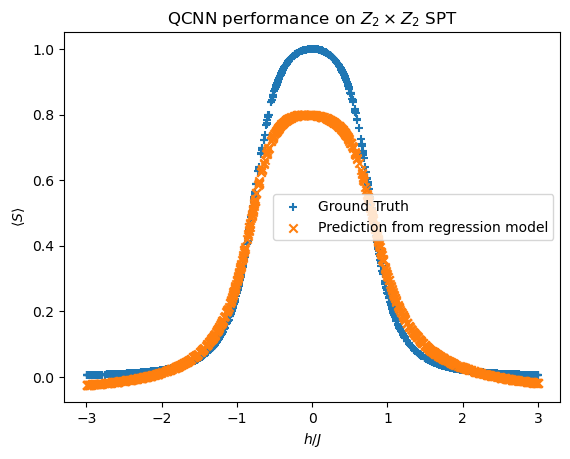

In [25]:
plt.scatter(h_list_spt, orderParams, marker = '+', label = 'Ground Truth')
plt.scatter(h_list_spt, pred_spt_regression, marker = "x", label = 'Prediction from regression model')
# plt.scatter(h_list_spt, pred_spt_regression_nonlocal, marker = "^", label = 'Prediction from regression model with nonlocal measurement')


plt.xlabel(r"$h/J$")
plt.ylabel(r"$\langle S\rangle$")
plt.legend()
plt.title(r'QCNN performance on $Z_2\times Z_2$ SPT')
# plt.savefig('plots/regression_spt.pdf')
plt.show()

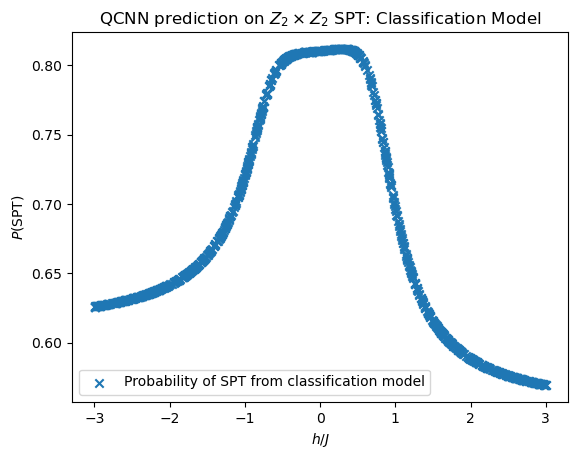

In [38]:
plt.scatter(h_list_spt, [x[1] for x in pred_spt_classification], marker = "x", label = 'Probability of SPT from classification model')
plt.xlabel(r"$h/J$")
plt.ylabel(r"$P$(SPT)")
plt.legend()
plt.title(r'QCNN prediction on $Z_2\times Z_2$ SPT: Classification Model')
plt.savefig('plots/classification_spt.pdf')
plt.show()

# Generate random 8-qubit state

In [27]:
N = 100
L=8
op = stringOp(L)
M_op = M(L)



random_states = []
random_magnetization = []
random_stringOp = []
for i in range(N):
    state = np.matrix(qutip.rand_ket(256).data.toarray())
    random_states.append(np.array(state.transpose()))
    m = np.matmul(state.H, np.matmul(M_op, state))
    random_magnetization.append(m.item())
    s = np.matmul(state.H, np.matmul(op, state))
    random_stringOp.append(s.item())

In [28]:
pred_spt_random = [QCNN_circuit.QCNN(x, params_spt_regression, 'U_SU4', 15, Embedding, 'mse') for x in random_states]
pred_ising_random = [QCNN_circuit.QCNN(x, params_ising_regression, 'U_SU4', 15, Embedding, 'mse') for x in random_states]

/Users/yaohong/opt/anaconda3/envs/qml/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


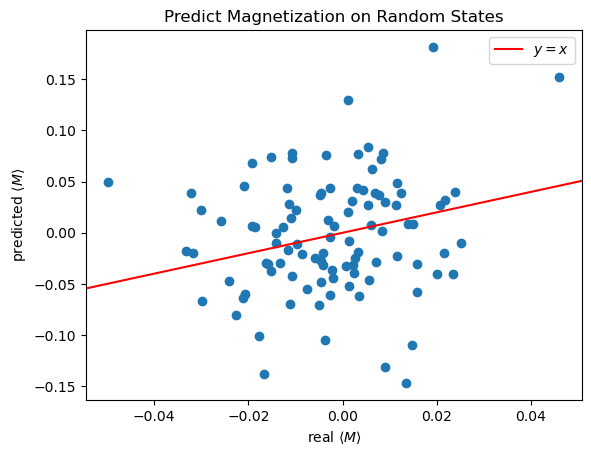

In [29]:
plt.scatter(random_magnetization, pred_ising_random)


plt.axline((-0.03,-0.03), (0.03, 0.03), label = r'$y=x$' , color = 'r')

plt.xlabel(r"real $\langle M\rangle$")
plt.ylabel(r"predicted $\langle M\rangle$")
plt.legend()
plt.title(r'Predict Magnetization on Random States')
plt.savefig('plots/predict_random_magnetization.pdf')
plt.show()

/Users/yaohong/opt/anaconda3/envs/qml/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


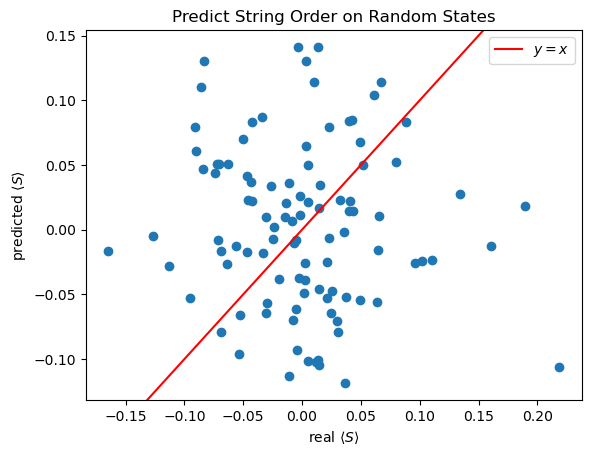

In [30]:
plt.scatter(random_stringOp, pred_spt_random)

plt.axline((-0.03,-0.03), (0.03, 0.03), label = r'$y=x$', color = 'r')

plt.xlabel(r"real $\langle S\rangle$")
plt.ylabel(r"predicted $\langle S\rangle$")
plt.legend()
plt.title(r'Predict String Order on Random States')
plt.savefig('plots/predict_random_string_order.pdf')
plt.show()

# Adding noise

In [31]:
def add_noise(ground_states, operator):
    L = int(np.log2(len(ground_states[0])))
    pauli_x = np.array([[0,1],[1,0]])
    pauli_z = np.array([[1,0],[0,-1]])
    id = np.eye(2)

    sx_list = []
    sz_list = []
    for i_site in range(L):
            z_ops = [id] * L
            x_ops = [id] * L
            z_ops[i_site] = pauli_z
            x_ops[i_site] = pauli_x
            ZZ = z_ops[0]
            X =  x_ops[0]
            for j in range(1, L):
                    ZZ = np.kron(ZZ, z_ops[j])
                    X = np.kron(X, x_ops[j])
            sz_list.append(ZZ)
            sx_list.append(X)
    # decide X or Z noise
    
    state_noise = []
    m_noise = []
    for state in ground_states:
        which = np.random.choice([0,1])
        if which==0:
            op_list = sx_list
        else:
            op_list = sz_list

        amp = (2 * np.pi * np.random.rand() - np.pi)/10
        qubit = np.random.choice(np.arange(L),2)
        
        op = np.matmul(op_list[qubit[0]], op_list[qubit[1]])
        
        state_n = np.matmul(expm(amp * 1J * op), state)
        state_noise.append(state_n)
        
        ket = np.transpose([state_n])
        
        m = np.matmul(np.matrix(ket).H, np.matmul(operator(L), ket))
        m_noise.append(m.item())
    
    return state_noise, m_noise
        
    
    
    
    

## Ising model

In [32]:
ising_states_noise, ising_magnetization_noise = add_noise(ground_states, M)

In [33]:
# Regression model
params_ising_regression = np.array([0.34484976, -0.28182233, -0.97583034, -1.50284213, -1.575846,    1.65898698,
 -0.85920524,  0.40488789, -1.57277551,  0.44711323, -0.61537749, -0.39033801,
 -2.24276353, -2.64576165, -1.09133645, -0.33006222,  0.32891585,  0.47062225,
  0.17388104, -0.55350894,  0.05721447,  1.61864024,  1.57273429, -1.53038872,
 -0.00724897,  1.20235452,  0.01119348, -1.69642161,  0.13043329, -0.33715001,
  0.11057712,  0.47717991,  0.97122175,  1.30935699, -0.23240944, -0.66083709,
  0.04738152, -2.70902228,  0.06163599, -0.21079841,  0.77414923, -0.70443353,
  0.39859975, -0.31522218, -1.54637845, -0.57939689,  0.7585887,  -0.4308167,
  0.15577493, -1.06197993, -0.35725969], requires_grad=False)
pred_ising_regression_noise = [QCNN_circuit.QCNN(x, params_ising_regression, ansatz, U_params, Embedding, 'mse') for x in ising_states_noise]

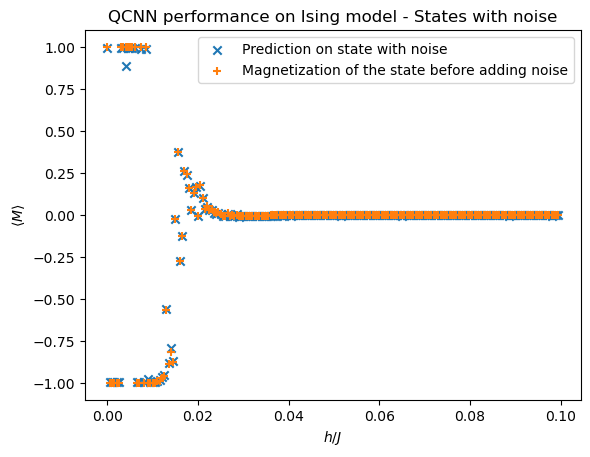

In [34]:
plt.scatter(h_list[:200], pred_ising_regression_noise[:200], label = 'Prediction on state with noise', marker = 'x')
plt.scatter(h_list[:200], magnetization[:200], label = 'Magnetization of the state before adding noise', marker = '+')
plt.legend()

plt.title(r'QCNN performance on Ising model - States with noise')
plt.savefig('plots/regression_ising_noise.pdf')
plt.xlabel(r'$h/J$')
plt.ylabel(r'$\langle M\rangle$')
plt.show()


## SPT

In [35]:
spt_states_noise, spt_magnetization_noise = add_noise(ground_states_spt, stringOp)

In [36]:
# Regression model
params_spt_regression = np.array([-0.35130076,  2.20147317,  0.4685366,  -0.11863158, -1.02904303,  0.23908072,
 -1.23517294,  0.27082562,  1.18944713,  0.05485146,  1.69398049,  0.98168833,
 -2.10962073, -0.8272562,   0.49564486, -1.56368582, -0.58283765,  0.83238825,
  0.01620159, -1.326686,   -0.41372758, -0.24921912, -2.30927844,  0.3357681,
  1.26383322, -1.44975513, -0.55086913,  1.07589775,  0.74656593, -2.29108514,
 -1.28677819,  1.81730066, -1.16639177,  2.20526573,  0.63912209,  0.30178217,
 -1.14256607,  0.70645885,  1.58831076, -0.85044413,  2.16992461, -0.72336096,
  0.68924927,  0.46234245, -2.07298505,  1.01307697,  0.64194001, -0.1594233,
 -1.12720285,  0.91683663,  2.22453806])
pred_spt_regression_noise = [QCNN_circuit.QCNN(x, params_spt_regression, 'U_SU4', 15, 'Statevector', 'mse') for x in spt_states_noise]

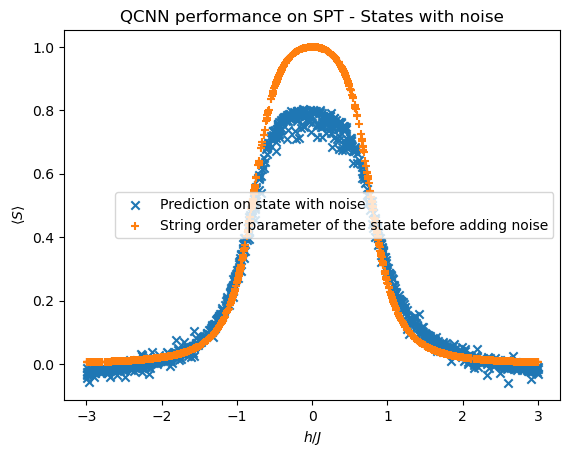

In [37]:
plt.scatter(h_list_spt, pred_spt_regression_noise, label = 'Prediction on state with noise', marker = 'x')
# plt.scatter(h_list_spt, spt_magnetization_noise, label = 'True string order on state with noise', marker = '.')
plt.scatter(h_list_spt, orderParams, label = 'String order parameter of the state before adding noise', marker = '+')
plt.legend()

plt.legend()


plt.title(r'QCNN performance on SPT - States with noise')
plt.savefig('plots/regression_spt_noise.pdf')

plt.xlabel(r'$h/J$')
plt.ylabel(r'$\langle S\rangle$')
plt.show()